Fitting 3 folds for each of 216 candidates, totalling 648 fits
Best hyperparameters found: {'bootstrap': False, 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       319
           1       0.55      0.34      0.42        35

    accuracy                           0.91       354
   macro avg       0.74      0.66      0.69       354
weighted avg       0.89      0.91      0.90       354

Final AUC: 0.8382892969099864


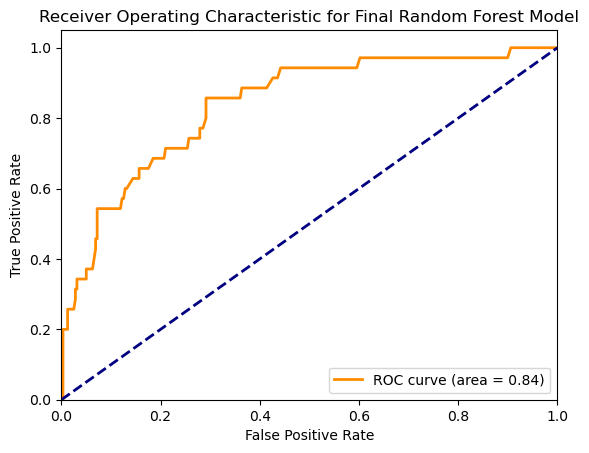

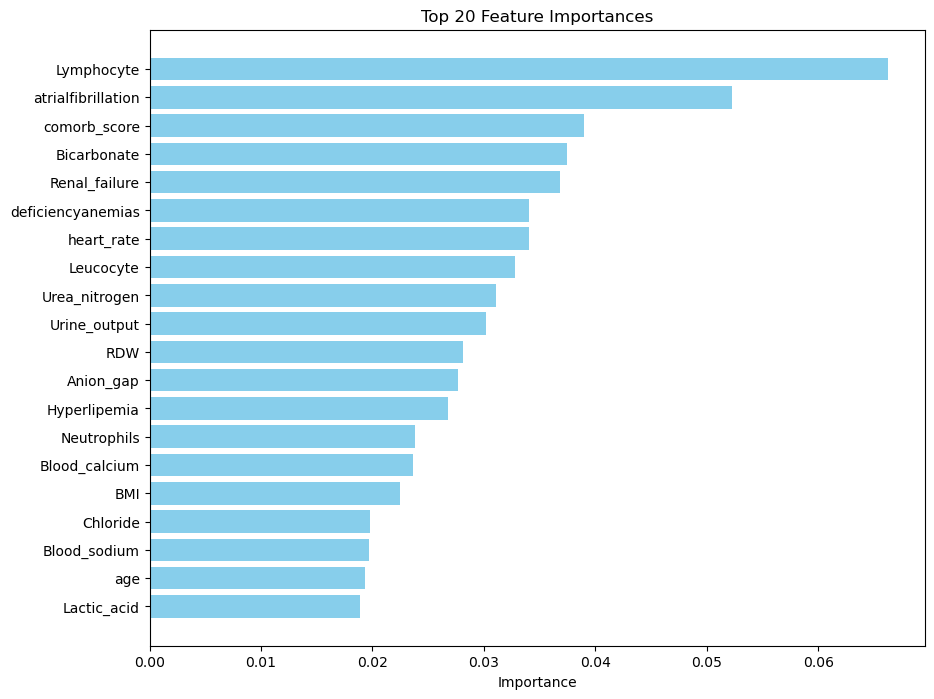

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

# Load and preprocess data
data = pd.read_csv("RF_imputation_NEW.csv")
data.drop(columns=['deathtime', 'survival_time', 'LOS', 'Unnamed_0', 'V1', 'admittime', 'ID', 'group', 'tLOS', 'subject_id'], inplace=True)
data['outcome'] = data['outcome'].astype(int)
predictor_names = data.columns.difference(['outcome'])

# Function to preprocess data
def preprocess_data(data, predictor_names, random_seed):
    scaler = StandardScaler()
    data[predictor_names] = scaler.fit_transform(data[predictor_names])
    train_data, valid_data = train_test_split(data, test_size=0.3, random_state=random_seed)
    return train_data, valid_data

# Preprocess the data
train_data, valid_data = preprocess_data(data, predictor_names, random_seed=42)

X_train = train_data[predictor_names].values
y_train = train_data['outcome'].values
X_valid = valid_data[predictor_names].values
y_valid = valid_data['outcome'].values

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Define the Random Forest model
rf = RandomForestClassifier(random_state=42)

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='roc_auc')
grid_search.fit(X_train_resampled, y_train_resampled)

# Best hyperparameters found
best_rf = grid_search.best_estimator_
print("Best hyperparameters found:", grid_search.best_params_)

# Train the final model with the best hyperparameters
best_rf.fit(X_train_resampled, y_train_resampled)

# Evaluate the final model
y_pred_proba_final = best_rf.predict_proba(X_valid)[:, 1]
y_pred_final = (y_pred_proba_final > 0.5).astype(int)

print(classification_report(y_valid, y_pred_final, zero_division=0))

# Calculate AUC for the final model
auc_final = roc_auc_score(y_valid, y_pred_proba_final)
print(f"Final AUC: {auc_final}")

# Plot ROC curve for the final model
fpr_final, tpr_final, thresholds_final = roc_curve(y_valid, y_pred_proba_final)
plt.figure()
plt.plot(fpr_final, tpr_final, color='darkorange', lw=2, label=f'ROC curve (area = {auc_final:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Final Random Forest Model')
plt.legend(loc="lower right")
plt.show()

# Calculate feature importances
feature_importances = best_rf.feature_importances_
features = predictor_names

# Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).head(20)


# Plot feature importances
plt.figure(figsize=(10, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Top 20 Feature Importances')
plt.gca().invert_yaxis()
plt.show()


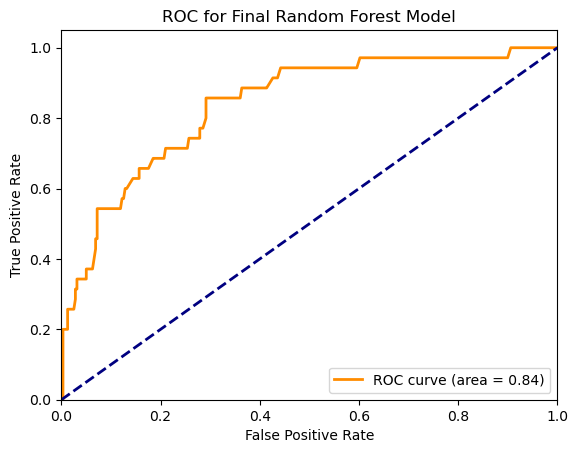

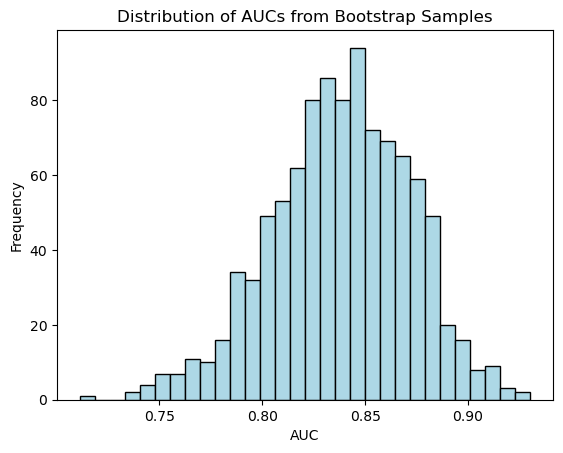

Mean AUC: 0.8381220659484911
Standard Error of AUC: 0.0010703286395437202
95% Confidence Interval: 0.7646453365297462 - 0.8997164133259195


In [8]:
# Plot ROC curve for the final model
fpr_final, tpr_final, thresholds_final = roc_curve(y_valid, y_pred_proba_final)
plt.figure()
plt.plot(fpr_final, tpr_final, color='darkorange', lw=2, label=f'ROC curve (area = {auc_final:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for Final Random Forest Model')
plt.legend(loc="lower right")
plt.show()

# Perform bootstrapping
n_bootstrap = 1000
bootstrap_aucs = []

for _ in range(n_bootstrap):
    X_valid_resample, y_valid_resample = resample(X_valid, y_valid)
    y_pred_proba_resample = best_rf.predict_proba(X_valid_resample)[:, 1]
    auc_resample = roc_auc_score(y_valid_resample, y_pred_proba_resample)
    bootstrap_aucs.append(auc_resample)

# Plot the distribution of AUC values
plt.figure()
plt.hist(bootstrap_aucs, bins=30, color='lightblue', edgecolor='black')
plt.xlabel('AUC')
plt.ylabel('Frequency')
plt.title('Distribution of AUCs from Bootstrap Samples')
plt.show()

# Calculate and print the mean and 95% confidence interval of AUC values
mean_auc = np.mean(bootstrap_aucs)
std_err_auc = np.std(bootstrap_aucs, ddof=1) / np.sqrt(n_bootstrap)
ci_lower = np.percentile(bootstrap_aucs, 2.5)
ci_upper = np.percentile(bootstrap_aucs, 97.5)

print(f"Mean AUC: {mean_auc}")
print(f"Standard Error of AUC: {std_err_auc}")
print(f"95% Confidence Interval: {ci_lower} - {ci_upper}")


In [9]:
print(bootstrap_aucs)

[0.8465741155396328, 0.8231814198071867, 0.8365843949044587, 0.8829218106995885, 0.8275680112570357, 0.8328197868087941, 0.8015873015873015, 0.7870729813664596, 0.8311237373737373, 0.8204657411553963, 0.8325177269549585, 0.8179466230936818, 0.8901982011992006, 0.8435866261398175, 0.8109600679694138, 0.8247418387741505, 0.8243361285814116, 0.85018315018315, 0.8255702917771884, 0.8834110592938041, 0.8796296296296297, 0.8485968241286328, 0.8569002329192547, 0.8844932844932845, 0.8542397020157757, 0.8197304995617879, 0.8793162247420924, 0.8114954577218728, 0.8493312757201646, 0.8425925925925926, 0.8587309429700735, 0.838487071977638, 0.8781432360742706, 0.8901554856743535, 0.840310341887629, 0.8419948107448108, 0.8351905244292059, 0.7883473095737247, 0.8769816390506046, 0.8487789384528515, 0.8472222222222222, 0.8889729299363057, 0.8906145902731513, 0.8387142452563014, 0.8316340979892383, 0.7503676470588236, 0.7781708595387841, 0.8292340884573894, 0.8069496021220159, 0.802880658436214, 0.81

In [10]:
df = pd.DataFrame(bootstrap_aucs, columns=['Value'])

# Save DataFrame to a CSV file
df.to_csv('rf_bootstrap.csv', index=False)
